In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import math
import copy

In [2]:
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Flatten, Dropout, Activation, Lambda, Permute, Reshape
from keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## This notebook as been tested with :
* Python 3.5
* Keras 2
* TensorFlow

In [3]:
from keras import backend as K
K.set_image_data_format( 'channels_last' ) # WARNING : important for images and tensors dimensions ordering
K.set_learning_phase(0)

## Build model architecture

In [4]:
def convblock(cdim, nb, bits=3):
    L = []
    
    for k in range(1,bits+1):
        convname = 'conv'+str(nb)+'_'+str(k)
        #L.append( Convolution2D(cdim, 3, 3, border_mode='same', activation='relu', name=convname) ) # Keras 1
        L.append( Convolution2D(cdim, kernel_size=(3, 3), padding='same', activation='relu', name=convname) ) # Keras 2
    
    L.append( MaxPooling2D((2, 2), strides=(2, 2)) )
    
    return L

In [5]:
def vgg_face_blank():
    
    withDO = True # no effect during evaluation but usefull for fine-tuning
    
    if True:
        mdl = Sequential()
        
        # First layer is a dummy-permutation = Identity to specify input shape
        mdl.add( Permute((1,2,3), input_shape=(224,224,3)) ) # WARNING : 0 is the sample dim

        for l in convblock(64, 1, bits=2):
            mdl.add(l)

        for l in convblock(128, 2, bits=2):
            mdl.add(l)
        
        for l in convblock(256, 3, bits=3):
            mdl.add(l)
            
        for l in convblock(512, 4, bits=3):
            mdl.add(l)
            
        for l in convblock(512, 5, bits=3):
            mdl.add(l)
        
        #mdl.add( Convolution2D(4096, 7, 7, activation='relu', name='fc6') ) # Keras 1
        mdl.add( Convolution2D(4096, kernel_size=(7, 7), activation='relu', name='fc6') ) # Keras 2
        if withDO:
            mdl.add( Dropout(0.5) )
        #mdl.add( Convolution2D(4096, 1, 1, activation='relu', name='fc7') ) # Keras 1
        mdl.add( Convolution2D(4096, kernel_size=(1, 1), activation='relu', name='fc7') ) # Keras 2
        if withDO:
            mdl.add( Dropout(0.5) )
        #mdl.add( Convolution2D(2622, 1, 1, name='fc8') ) # Keras 1
        mdl.add( Convolution2D(2622, kernel_size=(1, 1), activation='relu', name='fc8') ) # Keras 2
        mdl.add( Flatten() )
        mdl.add( Activation('softmax') )
        
        return mdl
    
    else:
        # See following link for a version based on Keras functional API :
        # gist.github.com/EncodeTS/6bbe8cb8bebad7a672f0d872561782d9
        raise ValueError('not implemented')

In [6]:
# Reference : https://github.com/rcmalli/keras-vggface
# Reference : gist.github.com/EncodeTS/6bbe8cb8bebad7a672f0d872561782d9

In [7]:
facemodel = vgg_face_blank()

In [8]:
facemodel.summary() # visual inspection of model architecture

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_1 (Permute)          (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 128)       0         
__________

## Load VGG weigths from .mat file

#### http://www.vlfeat.org/matconvnet/pretrained/#face-recognition
##### Download from console with :
wget http://www.vlfeat.org/matconvnet/models/vgg-face.mat

##### Alternatively :
wget http://www.robots.ox.ac.uk/~vgg/software/vgg_face/src/vgg_face_matconvnet.tar.gz

In [9]:
from scipy.io import loadmat

In [10]:
import os.path
os.path.exists('vgg-face.mat')
# os.listdir()

True

In [11]:
# if False: # INFO : use this if you downloaded weights from vlfeat.org
#     data = loadmat('vgg-face.mat', matlab_compatible=False, struct_as_record=False)
#     l = data['layers']
#     description = data['meta'][0,0].classes[0,0].description
# else: # INFO : use this if you downloaded weights from robots.ox.ac.uk
#     data = loadmat('vgg_face_matconvnet/data/vgg_face.mat', matlab_compatible=False, struct_as_record=False)
#     net = data['net'][0,0]
#     l = net.layers
#     description = net.classes[0,0].description

data = loadmat('vgg-face.mat', matlab_compatible=False, struct_as_record=False)
l = data['layers']
description = data['meta'][0,0].classes[0,0].description

In [12]:
l.shape, description.shape

((1, 37), (2622, 1))

In [13]:
l[0,10][0,0].type[0], l[0,10][0,0].name[0]

('conv', 'conv3_1')

In [14]:
l[0,10][0,0].weights[0,0].shape, l[0,10][0,0].weights[0,1].shape

((3, 3, 128, 256), (256, 1))

In [15]:
def weight_compare(kmodel):
    kerasnames = [lr.name for lr in kmodel.layers]

    # WARNING : important setting as 2 of the 4 axis have same size dimension
    #prmt = (3,2,0,1) # INFO : for 'th' setting of 'dim_ordering'
    prmt = (0,1,2,3) # INFO : for 'channels_last' setting of 'image_data_format'

    for i in range(l.shape[1]):
        matname = l[0,i][0,0].name[0]
        mattype = l[0,i][0,0].type[0]
        if matname in kerasnames:
            kindex = kerasnames.index(matname)
            print(matname, mattype)
            print(l[0,i][0,0].weights[0,0].transpose(prmt).shape, l[0,i][0,0].weights[0,1].shape)
            print(kmodel.layers[kindex].get_weights()[0].shape, kmodel.layers[kindex].get_weights()[1].shape)
            print('------------------------------------------')
        else:
            print('MISSING : ', matname, mattype)
            print('------------------------------------------')

In [16]:
#weight_compare(facemodel)

In [17]:
def copy_mat_to_keras(kmodel):

    kerasnames = [lr.name for lr in kmodel.layers]

    # WARNING : important setting as 2 of the 4 axis have same size dimension
    #prmt = (3,2,0,1) # INFO : for 'th' setting of 'dim_ordering'
    prmt = (0,1,2,3) # INFO : for 'channels_last' setting of 'image_data_format'

    for i in range(l.shape[1]):
        matname = l[0,i][0,0].name[0]
        if matname in kerasnames:
            kindex = kerasnames.index(matname)
            #print matname
            l_weights = l[0,i][0,0].weights[0,0]
            l_bias = l[0,i][0,0].weights[0,1]
            f_l_weights = l_weights.transpose(prmt)
            #f_l_weights = np.flip(f_l_weights, 2) # INFO : for 'th' setting in dim_ordering
            #f_l_weights = np.flip(f_l_weights, 3) # INFO : for 'th' setting in dim_ordering
            assert (f_l_weights.shape == kmodel.layers[kindex].get_weights()[0].shape)
            assert (l_bias.shape[1] == 1)
            assert (l_bias[:,0].shape == kmodel.layers[kindex].get_weights()[1].shape)
            assert (len(kmodel.layers[kindex].get_weights()) == 2)
            kmodel.layers[kindex].set_weights([f_l_weights, l_bias[:,0]])
            #print '------------------------------------------'

In [18]:
copy_mat_to_keras(facemodel)

### Test on squared and well centered image

In [19]:
im = Image.open('ak.png') # WARNING : this image is well centered and square
im = im.resize((224,224))

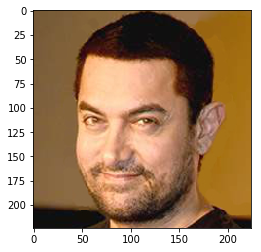

In [20]:
plt.imshow(np.asarray(im))

In [43]:
def pred(kmodel, crpimg, transform=False):
    
    # transform=True seems more robust but I think the RGB channels are not in right order
    
    imarr = np.array(crpimg).astype(np.float32)

    if transform:
        imarr[:,:,0] -= 129.1863
        imarr[:,:,1] -= 104.7624
        imarr[:,:,2] -= 93.5940
        #
        # WARNING : in this script (https://github.com/rcmalli/keras-vggface) colours are switched
        aux = copy.copy(imarr)
        #imarr[:, :, 0] = aux[:, :, 2]
        #imarr[:, :, 2] = aux[:, :, 0]

        #imarr[:,:,0] -= 129.1863
        #imarr[:,:,1] -= 104.7624
        #imarr[:,:,2] -= 93.5940

    #imarr = imarr.transpose((2,0,1)) # INFO : for 'th' setting of 'dim_ordering'
    imarr = np.expand_dims(imarr, axis=0)

    out = kmodel.predict(imarr)

    best_index = np.argmax(out, axis=1)[0]
    best_name = description[best_index,0]
#     print(best_index, best_name[0], out[0,best_index], [np.min(out), np.max(out)])
    return(best_name[0])

In [22]:
def preprocess(crpimg, transform=False):
        
    # transform=True seems more robust but I think the RGB channels are not in right order
    
    imarr = np.array(crpimg).astype(np.float32)

    if transform:
        imarr[:,:,0] -= 129.1863
        imarr[:,:,1] -= 104.7624
        imarr[:,:,2] -= 93.5940
        #
        # WARNING : in this script (https://github.com/rcmalli/keras-vggface) colours are switched
        aux = copy.copy(imarr)
        #imarr[:, :, 0] = aux[:, :, 2]
        #imarr[:, :, 2] = aux[:, :, 0]

        #imarr[:,:,0] -= 129.1863
        #imarr[:,:,1] -= 104.7624
        #imarr[:,:,2] -= 93.5940

    #imarr = imarr.transpose((2,0,1)) # INFO : for 'th' setting of 'dim_ordering'
    imarr = np.expand_dims(imarr, axis=0)
    
    return imarr
    

In [23]:
crpim = im # WARNING : we deal with cropping in a latter section, this image is already fit

pred(facemodel, crpim, transform=False)
pred(facemodel, crpim, transform=True)

2 Aamir_Khan 0.99443793 [9.476131e-09, 0.99443793]
2 Aamir_Khan 0.9444375 [2.2034408e-06, 0.9444375]


In [24]:
[(i, s[0]) for i, s in enumerate(description[:,0]) if ('laurie'.lower() in s[0].lower())]

[(861, 'Hugh_Laurie'), (1445, 'Laurie_Holden')]

In [25]:
description[100,0][0]

'America_Ferrera'

## Face Feature Vector : drop the last layer

In [26]:
featuremodel = Model(inputs=facemodel.layers[0].input, outputs=facemodel.layers[-2].output)

In [27]:
def features(featmodel, crpimg, transform=False):
    
    # transform=True seems more robust but I think the RGB channels are not in right order
    
    imarr = np.array(crpimg).astype(np.float32)

    if transform:
        imarr[:,:,0] -= 129.1863
        imarr[:,:,1] -= 104.7624
        imarr[:,:,2] -= 93.5940
        #
        # WARNING : in this script (https://github.com/rcmalli/keras-vggface) colours are switched
        aux = copy.copy(imarr)
        #imarr[:, :, 0] = aux[:, :, 2]
        #imarr[:, :, 2] = aux[:, :, 0]

        #imarr[:,:,0] -= 129.1863
        #imarr[:,:,1] -= 104.7624
        #imarr[:,:,2] -= 93.5940

    #imarr = imarr.transpose((2,0,1))
    imarr = np.expand_dims(imarr, axis=0)

    fvec = featmodel.predict(imarr)[0,:]
    # normalize
    normfvec = math.sqrt(fvec.dot(fvec))
    return fvec/normfvec

In [28]:
f = features(featuremodel, crpim, transform=True)

In [29]:
f.shape, f.dot(f)

((2622,), 0.99999994)

## Face extraction + Face identification
#### This requires OpenCV :
https://pypi.python.org/pypi/opencv-python
#### See this tutorial on face CascadeClassifier :
https://realpython.com/blog/python/face-recognition-with-python/

In [30]:
import cv2

In [31]:
# imagePath = 'Aamir_Khan.jpg'
imagePath = 'faces/Wayne_Knight/Wayne_Knight.jpg'
#imagePath = 'mzaradzki.jpg'
#imagePath = 'hugh_laurie.jpg'
#imagePath = 'Colin_Firth.jpg'
#imagePath = 'someguy.jpg'

Found 1 faces!


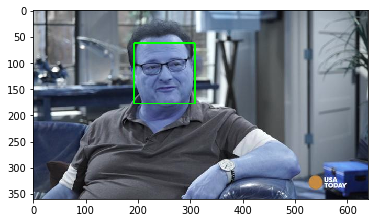

In [32]:
# WARNING : cascade XML file from this repo : https://github.com/shantnu/FaceDetect.git
faceCascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")

# Read the image
image = cv2.imread(imagePath)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Detect faces in the image
faces = faceCascade.detectMultiScale(
    gray,
    scaleFactor=1.1,
    minNeighbors=5,
    minSize=(30, 30)
)
faces = faceCascade.detectMultiScale(gray, 1.2, 5)

print("Found {0} faces!".format(len(faces)))

# Draw a rectangle around the faces
for (x, y, w, h) in faces:
    cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)

plt.imshow(image)

In [33]:
def get_Face(imagePath):
    # Read the image
    image = cv2.imread(imagePath)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect faces in the image
    faces = faceCascade.detectMultiScale(
        gray,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(30, 30)
    )
    faces = faceCascade.detectMultiScale(gray, 1.2, 5)
    
    im = Image.open(imagePath)

    (x, y, w, h) = faces[0]

    center_x = x+w//2
    center_y = y+h//2
    b_dim = min(max(w,h)*1.2,im.width, im.height) # WARNING : this formula in incorrect
    #box = (x, y, x+w, y+h)
    box = (center_x-b_dim/2, center_y-b_dim/2, center_x+b_dim/2, center_y+b_dim/2)
    # Crop Image
    crpim = im.crop(box).resize((224,224))
    
    return crpim

2552 Wayne_Knight 0.99994636 [1.0452361e-11, 0.99994636]
2552 Wayne_Knight 0.99480706 [1.241638e-07, 0.99480706]


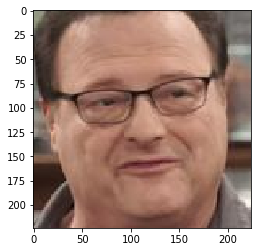

In [34]:
# im = Image.open(imagePath)

# (x, y, w, h) = faces[0]
# center_x = x+w/2
# center_y = y+h/2
# b_dim = min(max(w,h)*1.2,im.width, im.height) # WARNING : this formula in incorrect
# #box = (x, y, x+w, y+h)
# box = (center_x-b_dim/2, center_y-b_dim/2, center_x+b_dim/2, center_y+b_dim/2)
# # Crop Image
# crpim = im.crop(box).resize((224,224))

crpim = np.array(get_Face(imagePath))
# print(crpim)
plt.imshow(np.asarray(crpim))

pred(facemodel, crpim, transform=False)
pred(facemodel, crpim, transform=True)

In [35]:
os.listdir('faces')

['Stephen_Root', 'Wayne_Knight']

In [36]:
def get_validation(path):
    x = []
    y = []
    for root, directories, filenames in os.walk('faces'):
    #     for directory in directories:
    #         print (os.path.join(root, directory))
        for filename in filenames: 
            print (os.path.join(root,filename))
            try:
                immar = np.array(get_Face(os.path.join(root,filename)))
#                 immar = np.expand_dims(immar, axis=0)
                x.append(immar)
                y.append(root.split('/')[-1])
            except:
                pass
#     x = np.array(x)
#     y = np.array(y)
    return np.array(x), np.array(y)
#     return x, y

In [53]:
def validation(y_true, y_val):
    k = 0
    for i in range(len(y_true)):
        if y_true[i] == y_val[i]:
            k += 1
            
    return k/len(y_val)

In [37]:
# x = []
# y = []
# for root, directories, filenames in os.walk('faces'):
# #     for directory in directories:
# #         print (os.path.join(root, directory))
#     for filename in filenames: 
#         print (os.path.join(root,filename))
#         x.append(np.array(get_Face(os.path.join(root,filename))))
#         y.append(root.split('/')[-1])
# x = np.array(x)
# y = np.array(y)

In [38]:
x, y = get_validation('faces')

# for i in x:
#     pred(facemodel, i, transform=False)
# pred(facemodel, i, transform=False)

faces/Stephen_Root/Stephen_Root6.jpg
faces/Stephen_Root/Stephen_Root4.jpeg
faces/Stephen_Root/Stephen_Root.jpg
faces/Stephen_Root/Stephen_Root7.jpg
faces/Stephen_Root/Stephen_Root9.jpeg
faces/Stephen_Root/Stephen_Root2.jpg
faces/Stephen_Root/Stephen_Root8.jpeg
faces/Stephen_Root/Stephen_Root5.jpeg
faces/Stephen_Root/Stephen_Root3.jpeg
faces/Stephen_Root/Stephen_Root10.jpeg
faces/Wayne_Knight/Wayne_Knight8.jpg
faces/Wayne_Knight/Wayne_Knight9.jpg
faces/Wayne_Knight/Wayne_Knight4.jpg
faces/Wayne_Knight/Wayne_Knight.jpg
faces/Wayne_Knight/Wayne_Knight10.jpg
faces/Wayne_Knight/Wayne_Knight6.jpg
faces/Wayne_Knight/Wayne_Knight7.jpg
faces/Wayne_Knight/Wayne_Knight3.jpg
faces/Wayne_Knight/Wayne_Knight2.jpg


In [39]:
y

array(['Stephen_Root', 'Stephen_Root', 'Stephen_Root', 'Stephen_Root',
       'Stephen_Root', 'Stephen_Root', 'Stephen_Root', 'Stephen_Root',
       'Stephen_Root', 'Stephen_Root', 'Wayne_Knight', 'Wayne_Knight',
       'Wayne_Knight', 'Wayne_Knight', 'Wayne_Knight', 'Wayne_Knight',
       'Wayne_Knight', 'Wayne_Knight', 'Wayne_Knight'], dtype='<U12')

In [48]:
y_pred = []
for i in x:
    y_pred.append(pred(facemodel, i))

In [54]:
validation(y, y_pred)

1.0

In [ ]:
# preds = facemodel.predict(x)
# facemodel.predict_classes(x)
# print('Predicted:', K.applications.decode_predictions(preds,top=2))

In [33]:
#####attack
import foolbox

In [41]:
fmodel = foolbox.models.KerasModel(facemodel, bounds=(0, 255), preprocessing=preprocess)

TypeError: object of type 'function' has no len()

In [42]:
description[:20,0]

array([array(['A.J._Buckley'], dtype='<U12'),
       array(['A.R._Rahman'], dtype='<U11'),
       array(['Aamir_Khan'], dtype='<U10'),
       array(['Aaron_Staton'], dtype='<U12'),
       array(['Aaron_Tveit'], dtype='<U11'),
       array(['Aaron_Yoo'], dtype='<U9'),
       array(['Abbie_Cornish'], dtype='<U13'),
       array(['Abel_Ferrara'], dtype='<U12'),
       array(['A_P_J_Abdul_Kalam'], dtype='<U17'),
       array(['Abigail_Breslin'], dtype='<U15'),
       array(['Abigail_Klein'], dtype='<U13'),
       array(['Abigail_Spencer'], dtype='<U15'),
       array(['Abraham_Benrubi'], dtype='<U15'),
       array(['Adam_Baldwin'], dtype='<U12'),
       array(['Adam_Beach'], dtype='<U10'),
       array(['Adam_Brody'], dtype='<U10'),
       array(['Adam_Buxton'], dtype='<U11'),
       array(['Adam_Copeland'], dtype='<U13'),
       array(['Adam_Driver'], dtype='<U11'),
       array(['Adam_G._Sevani'], dtype='<U14')], dtype=object)

In [8]:
import numpy as np
import keras
from keras.preprocessing import image
from keras_vggface.vggface import VGGFace
from keras_vggface import utils

model = VGGFace(model='vgg16')

In [46]:
# img = image.load_img('../image/ajb.jpg', target_size=(224, 224))
img = keras.preprocessing.image.load_img('Aamir_Khan.jpg', target_size=(224, 224))
x = keras.preprocessing.image.img_to_array(crpim)
x = np.expand_dims(x, axis=0)
x = utils.preprocess_input(x, version=1) # or version=2
preds = model.predict(x)
print('Predicted:', utils.decode_predictions(preds,top=100))

Predicted: [[["b'Stephen_Root'", 0.9946197], ["b'Jared_Harris'", 0.00042945918], ["b'Stephen_Lang'", 0.0004147724], ["b'Rhys_Darby'", 0.0003994667], ["b'John_DiMaggio'", 0.00038919362], ["b'Will_Mellor'", 0.0002523288], ["b'Dave_Foley'", 0.0002032442], ["b'Ted_Levine'", 0.00019009922], ["b'Tom_Kenny'", 0.00018047047], ["b'James_Lipton'", 0.0001737278], ["b'Adam_Copeland'", 0.00013937007], ["b'Randy_Wayne'", 0.0001372571], ["b'Wayne_Knight'", 9.378886e-05], ["b'Brian_Blessed'", 8.0868784e-05], ["b'Bradley_Steven_Perry'", 7.308123e-05], ["b'Tommy_Morrison'", 6.968121e-05], ["b'Andrea_Roth'", 6.511848e-05], ["b'Titus_Welliver'", 6.4708605e-05], ["b'Jim_Henson'", 6.141562e-05], ["b'Crystal_Allen'", 6.077275e-05], ["b'Fred_Willard'", 5.8583028e-05], ["b'Abraham_Benrubi'", 4.3344764e-05], ["b'Dave_Bautista'", 3.935536e-05], ["b'Dwight_Schultz'", 3.7716956e-05], ["b'Dawna_Lee_Heising'", 3.7227943e-05], ["b'Chris_Bauer'", 3.4900782e-05], ["b'Jeff_Fahey'", 2.6572368e-05], ["b'Martin_Shaw'", 2.5

In [37]:
def prep(img):
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = utils.preprocess_input(x, version=1) # or version=2
    return x

In [17]:
img2 = image.load_img('faces/Craig_Robinson.jpeg', target_size=(224, 224))
img2 = prep(img2)
preds = model.predict(x)
print('Predicted:', utils.decode_predictions(preds,top=1))

Predicted: [[["b'Wayne_Knight'", 0.022779955]]]


In [4]:
#####attack
import foolbox

In [61]:
fmodel = foolbox.models.KerasModel(model, bounds=(0, 255), preprocessing=preprocessing)

In [47]:
# preds.argmax(axis=-1)

In [55]:
# get source image and label
# image, label = foolbox.utils.imagenet_example()

image = np.array(crpim)

label = 'Stephen_Root'

# apply attack on source image
# ::-1 reverses the color channels, because Keras ResNet50 expects BGR instead of RGB
attack = foolbox.attacks.FGSM(fmodel)
adversarial = attack(image[:, :, ::-1], label)

/usr/local/lib/python3.6/dist-packages/foolbox/attacks/base.py:93: UserWarning: Not running the attack because the original input is already misclassified and the adversarial thus has a distance of 0.
  warnings.warn('Not running the attack because the original input'
